# 데이터
1991년 7월부터 2008년 6월까지 월 단위(monthly)로 집계된 약 판매량 시계열 데이터셋

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'https://raw.githubusercontent.com/selva86/datasets/master/a10.csv'
df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')

- 선형 추세 존재
- 년 단위 계절성 존재

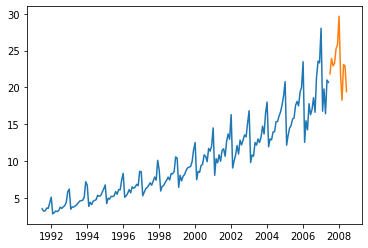

In [3]:
df_train = df.iloc[:-12]
df_test = df.iloc[-12:]
plt.plot(np.array(df_train.index),df_train)
plt.plot(np.array(df_test.index),df_test)
plt.show()

In [39]:
# 7,8,9로 합쳐져야 -> 7로 표시되게
df_train

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2007-02-01,16.763869
2007-03-01,19.792754
2007-04-01,16.427305


분해법을 이용해 test 데이터 예측

1. 중심 이동평균으로 평활치 산출
2. 추세제거
3. 계절성 지수 산출
4. 계절성 제거(deseasonalized) 시계열 산출
5. 회귀모형으로 추세 추정
6. 추세 및 계절성 지수를 결합하여 예측치 산출

## 1) 중심 이동평균
m = 12

In [46]:
# m이 짝수이므로 각 window의 처음과 끝은 반만 계산해줘야하나 그냥 무시
CM = df_train.rolling(12, center=True).mean()
CM.iloc[3:12]

,value
date,
1991-10-01,NaN
1991-11-01,NaN
1991-12-01,NaN
1992-01-01,3.494541
1992-02-01,3.512146
1992-03-01,3.543636
1992-04-01,3.587385
1992-05-01,3.613509
1992-06-01,3.681897


In [4]:
# m이 짝수이므로 각 window의 처음과 끝은 반만 계산해줘야하나 그냥 무시
m = 4
CM_4 = df_train.rolling(4, center=True).mean()
CM_4.iloc[3:12]

,value
date,
1991-10-01,3.402496
1991-11-01,3.683866
1991-12-01,4.142895
1992-01-01,3.943774
1992-02-01,3.798759
1992-03-01,3.523362
1992-04-01,3.033172
1992-05-01,3.147173
1992-06-01,3.335183


## 2) 추세제거 시계열

In [47]:
DX = df_train/CM

In [48]:
DX.iloc[3:12]

,value
date,
1991-10-01,NaN
1991-11-01,NaN
1991-12-01,NaN
1992-01-01,1.456081
1992-02-01,0.801368
1992-03-01,0.842584
1992-04-01,0.893347
1992-05-01,0.865524
1992-06-01,0.888271


In [5]:
DX_4 = df_train/CM_4
DX_4.iloc[:10]

,value
date,
1991-07-01,NaN
1991-08-01,NaN
1991-09-01,0.958600
1991-10-01,1.061281
1991-11-01,0.967969
1991-12-01,1.039459
1992-01-01,1.290220
1992-02-01,0.740905
1992-03-01,0.847432


## 3) 계절성 지수
추세제거 시계열

In [143]:
from pandas.tseries.offsets import YearBegin
offset = YearBegin()
S = DX.groupby(offset.rollback).mean()
S = S/S.mean()
S

,value
date,
1991-01-01,NaN
1992-01-01,0.977994
1993-01-01,0.989643
1994-01-01,0.970595
1995-01-01,0.970855
1996-01-01,0.986487
1997-01-01,0.982912
1998-01-01,0.970032
1999-01-01,0.973549


In [32]:
from pandas.tseries.offsets import QuarterBegin
offset = QuarterBegin()
S_4 = DX_4.groupby(offset.rollforward).mean()
S_4 = S_4/S_4.mean()
S_4

,value
date,
1991-09-01,0.955944
1991-12-01,1.020068
1992-03-01,0.956860
1992-06-01,1.007521
1992-09-01,1.027649
...,...
2006-06-01,1.017860
2006-09-01,0.985441
2006-12-01,1.045975


## 4) 계절성 제거 시계열

In [17]:
# val_2007 = S_4.resample("MS").pad().iloc[-1,0]
# temp = pd.DataFrame(index = pd.date_range(start='2007/01/01',end='2007/12/31',freq='MS'))
# temp.index.name = 'date'
# temp['value'] = val_2007

In [36]:
S_resample_4 = S_4.resample("MS").pad()
S_resample_4.iloc[-15:-8]

,value
date,
2006-04-01,0.960139
2006-05-01,0.960139
2006-06-01,1.017860
2006-07-01,1.017860
2006-08-01,1.017860
2006-09-01,0.985441
2006-10-01,0.985441


In [20]:
DX_s_4 = df_train/S_resample_4
DX_s_4.iloc[15:20]

,value
date,
1992-04-01,3.179907
1992-05-01,3.103304
1992-06-01,3.245140
1992-07-01,3.708840
1992-08-01,3.531155


In [38]:
S_resample_4

,value
date,
1991-09-01,0.955944
1991-10-01,0.955944
1991-11-01,0.955944
1991-12-01,1.020068
1992-01-01,1.020068
...,...
2007-02-01,1.045975
2007-03-01,0.984812
2007-04-01,0.984812


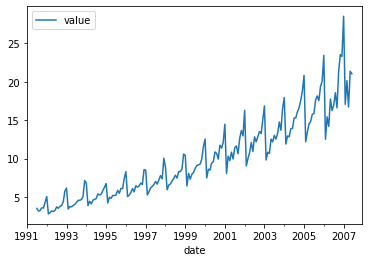

In [37]:
# 이게 계절성 제거된거??
DX_s_4.plot()

In [24]:
S_resample_4.groupby(S_resample_4.index.year).mean()

,value
date,
1991,1.003931
1992,1.007822
1993,1.005444
1994,0.991443
1995,0.999975
1996,1.004228
1997,1.004918
1998,0.996853
1999,0.998628
